02450 Project 2

In [15]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.datasets as datasets
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

import sklearn.linear_model as lm
from matplotlib.pylab import figure, hist, plot, show, subplot, xlabel, ylabel
from sklearn import model_selection

from dtuimldmtools import *
from dtuimldmtools.statistics.statistics import correlated_ttest



Load data from csv file

In [3]:
cwd = os.getcwd()
data = pd.read_csv(cwd + '/usa_wood_data_formatted.csv')
# print(data.head())  


Clean data by removing columns with significant amount of missing values

In [34]:
removed_columns = ['side_hardness','tension_perpendicular_to_grain','impact_bending']
data_cleaned = data.drop(columns=removed_columns)
data_cleaned = data_cleaned.dropna()
print(data_cleaned.isnull().sum()) # 0 means data is clean

data_arr = np.array(data_cleaned)  # Attributes are columns
attributeNames = [name for name in data_cleaned.columns]
attributeNames = attributeNames[7:12]
print(attributeNames)

for i in range(data_arr.shape[1] - 6):      # Adjust data for zero mean and stddev 1
    M = data_arr[:,i+6]
    data_arr[:,i+6] = (M - np.mean(M))/(np.std(M))


y = data_arr[:,6]
X = data_arr[:,7:12]
N, M = X.shape

common_species_name                   0
genus                                 0
species                               0
scientific_name                       0
classification                        0
moisture_content                      0
specific_gravity                      0
modulus_of_rupture                    0
modulus_of_elasticity                 0
work_to_maximum_load                  0
compression_parallel_to_grain         0
compression_perpendicular_to_grain    0
shear_parallel_to_grain               0
dtype: int64
['modulus_of_rupture', 'modulus_of_elasticity', 'work_to_maximum_load', 'compression_parallel_to_grain', 'compression_perpendicular_to_grain']


Linear Regression

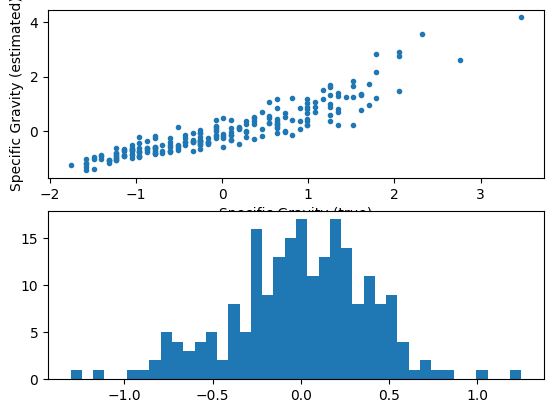

In [13]:
# Fit ordinary least squares regression model
model = lm.LinearRegression(fit_intercept=True)
model = model.fit(X, y)
# Compute model output:
y_est = model.predict(X)
residual = y_est - y

# Display scatter plot
figure()
subplot(2, 1, 1)
plot(y, y_est, ".")
xlabel("Specific Gravity (true)")
ylabel("Specific Gravity (estimated)")
subplot(2, 1, 2)
hist(residual, 40)

show()

Feature Selection 

<generator object _BaseKFold.split at 0x0000025D8A0EFC80>
Cross validation fold 1/10
Train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  20  21  22  24  26  27  28  29  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57  58
  60  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  87  88  89  90  91  93  94  95  96  97  98  99
 100 101 103 104 105 106 108 109 110 111 112 113 114 115 116 119 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 174 175 176 177 178 179 181
 182 183 184 185 186 187 188 189 190 191 192 193 195 196 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213]
Test indices: [ 19  23  25  30  51  59  61  70  86  92 102 107 117 118 120 121 143 144
 173 180 194 197]
Features no: 4


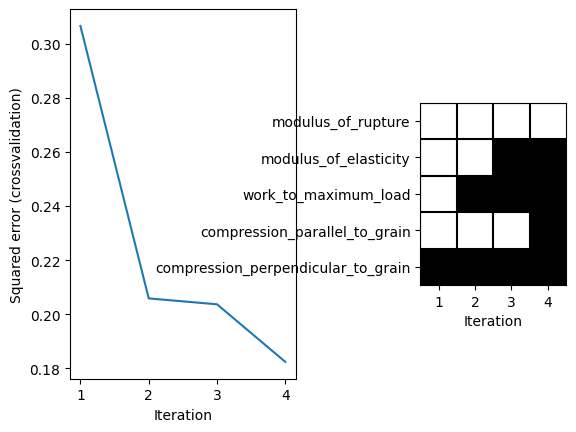

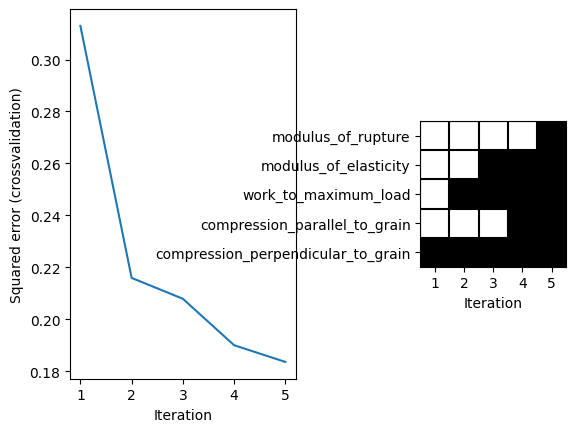

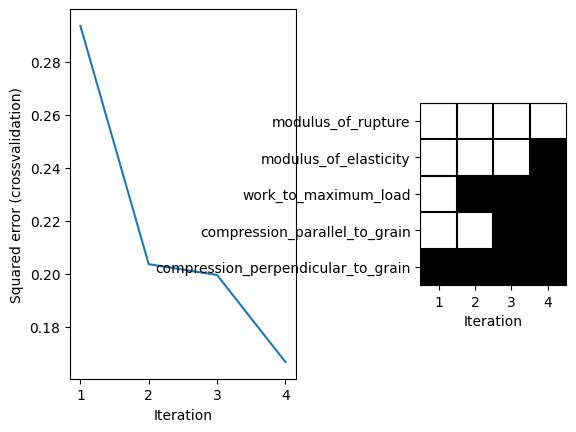

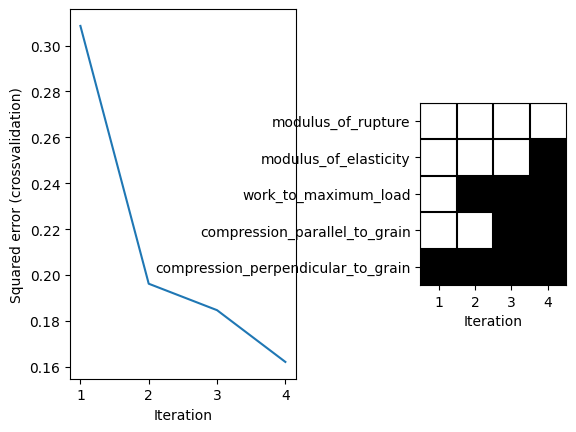

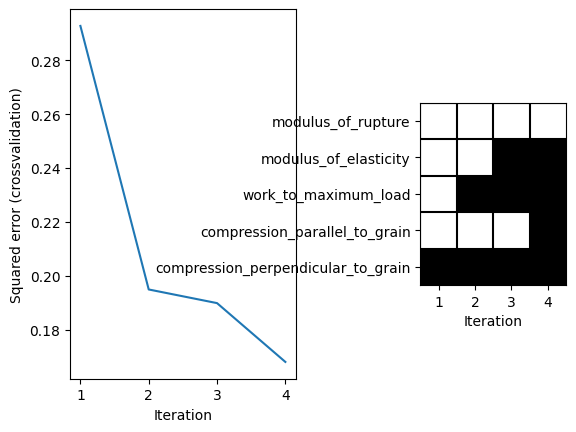

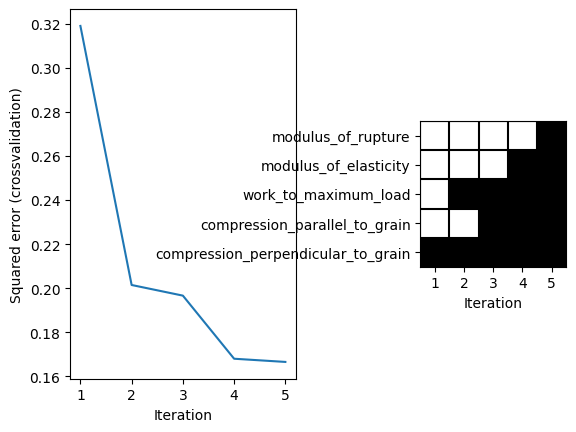

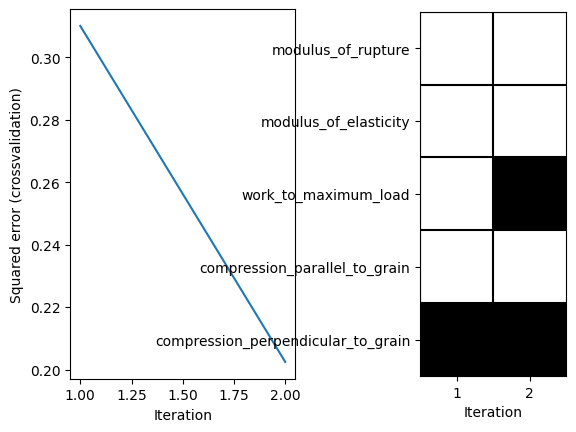

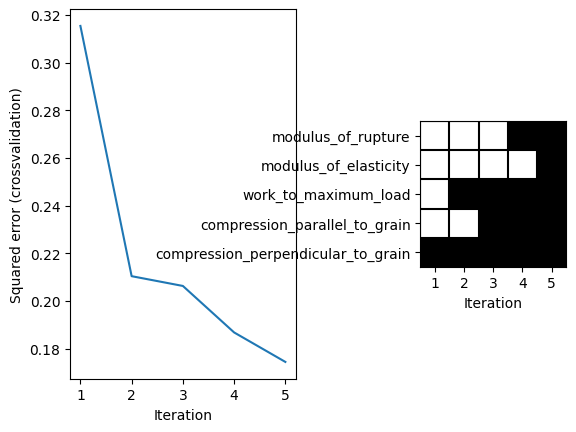

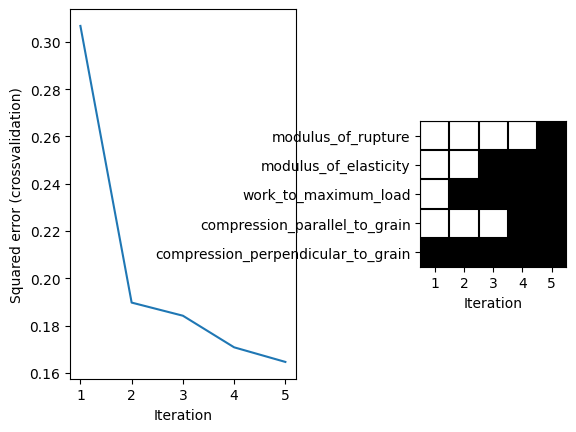

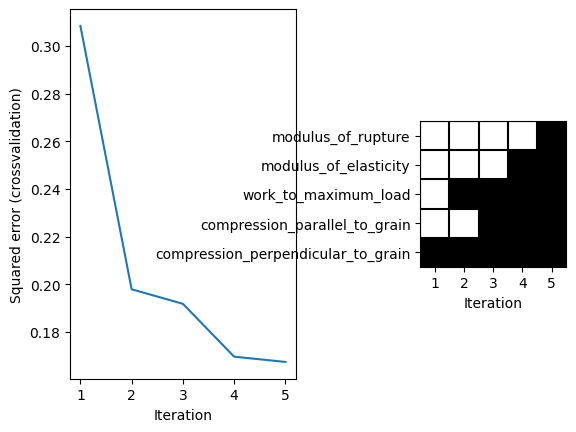

In [35]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
print(CV.split(X))
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        #clim(-1.5,0)
        xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))

    k+=1


# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))
